In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from sklearn.linear_model import TheilSenRegressor
%matplotlib qt

### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(250)

cv2.destroyAllWindows()

### Apply a distortion correction to raw images.

In [3]:
undistorted_images = {}

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Calibrate the camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    # Undistort the image
    undistorted_images[fname] = cv2.undistort(img, mtx, dist, None, mtx)

### Use color transforms, gradients, etc., to create a thresholded binary image.

In [4]:
def threshold(image, thresholds):
    binary = np.zeros_like(image)
    binary[(image > thresholds[0]) & (image <= thresholds[1])] = 255
    return binary

In [5]:
#%matplotlib inline

# Make a list of lane images
lane_images = glob.glob('test_images/*.jpg')
combined_images = []

for fname in lane_images:
    
    img = cv2.imread(fname)
    
    gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    H = hls_image[:,:,0]
    L = hls_image[:,:,1]
    S = hls_image[:,:,2]
    
    # Obtain the thresholded saturation channel
    focus = threshold(S, (170, 255))
    
    # Take the derivative w.r.t to the x direction and scale it
    deriv_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0)
    deriv_x = np.abs(deriv_x)
    deriv_x = np.uint8(255 * deriv_x/np.max(deriv_x))
    
    # Obtain the thresholded gradient
    gradient = threshold(deriv_x, (70, 200))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(gradient)
    combined_binary[(gradient == 255) | (focus == 255)] = 255

    plt.imshow(combined_binary)
    plt.show()
    combined_images.append(combined_binary)

### Apply a perspective transform to rectify binary image ("birds-eye view")

In [6]:
percentage_left_right = 0.45
percentage_top = 0.60

def region_of_interest(image):
    """
    Obtains a region of interest for the given image
    """
    mask = np.zeros_like(image)
    ignore_mask_color = 255

    imshape = image.shape

    vertices = np.array([[(0, imshape[0]),
                          (imshape[1] * percentage_left_right, imshape[0] * percentage_top),
                          (imshape[1] * (1 - percentage_left_right), imshape[0] * percentage_top),
                          (imshape[1], imshape[0])]], dtype=np.int32)

    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(image, mask)

    return masked_edges, np.float32(vertices[0])

In [7]:
def bird_view(image):
    
    # Find the width and height of the image
    h, w = image.shape[:2]

#     src = np.array([(0, h), # Bottom left
#                     (w * percentage_left_right, h * percentage_top), # Top left
#                     (w * (1 - percentage_left_right), h * percentage_top), # Top right
#                     (w, h)], dtype=np.float32) # Bottom right
    
    src = np.float32([[0, h-10],    # bl
                      [546, 460],   # tl
                      [732, 460],  # tr
                      [w, h-10]])    # br

    dst = np.float32([(0, h), # bottom left
                      (0, 0), # top left
                      (w, 0), # top right
                      (w, h)]) # bottom right
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, (w, h), flags=cv2.INTER_NEAREST)
    
    return warped

In [10]:
def find_lane_pixels(bird_view_image):
    
    histogram = np.sum(bird_view_image[bird_view_image.shape[0]//2:,:], axis=0)
    
    height, width = bird_view_image.shape[:2]
    
    # Find the starting points
    mid_point = np.int(width // 2)
    left_x_base = np.argmax(histogram[:mid_point])
    right_x_base = np.argmax(histogram[mid_point:]) + mid_point
    
    NUMBER_OF_WINDOWS = 20
    MARGIN = 100
    MIN_PIXELS = 30
    
    window_height = np.int(height // NUMBER_OF_WINDOWS)
    
    nonzero = bird_view_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_x_current = left_x_base
    right_x_current = right_x_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    out_img = np.dstack((bird_view_image, bird_view_image, bird_view_image))
    
    for slice_ in range(NUMBER_OF_WINDOWS + 1):
        y_bottom = height - (slice_ *  window_height)
        y_top = y_bottom - window_height
        
        win_y_low = bird_view_image.shape[0] - (slice_+1)* window_height
        win_y_high = bird_view_image.shape[0] - slice_* window_height
    
        win_xleft_low = left_x_current - MARGIN
        win_xleft_high = left_x_current + MARGIN
        win_xright_low = right_x_current - MARGIN
        win_xright_high = right_x_current + MARGIN
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high, win_y_high),(0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > MIN_PIXELS:
            left_x_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > MIN_PIXELS:
            right_x_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_model(binary_warped):
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    Y_left = np.column_stack([lefty, lefty**2])
    Y_right = np.column_stack([righty, righty**2])
    
    left_fit = TheilSenRegressor().fit(Y_left, leftx)
    right_fit = TheilSenRegressor().fit(Y_right, rightx)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit.coef_[1]*ploty**2 + left_fit.coef_[0]*ploty + left_fit.intercept_
    right_fitx = right_fit.coef_[1]*ploty**2 + right_fit.coef_[0]*ploty + right_fit.intercept_

    ## Visualization ##
    # Colors in the left and right lane regions 
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return out_img

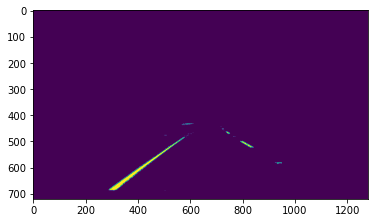

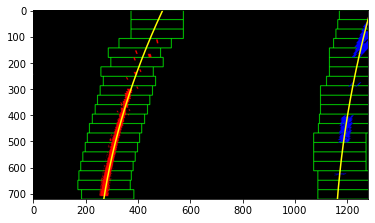

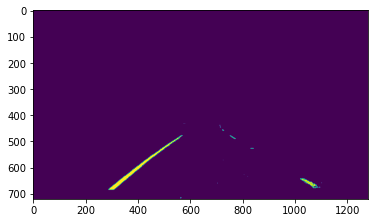

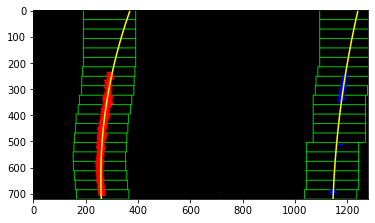

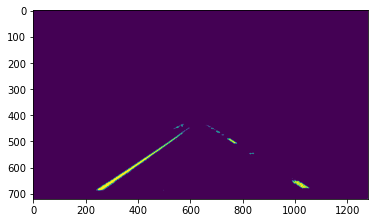

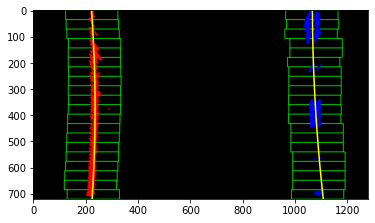

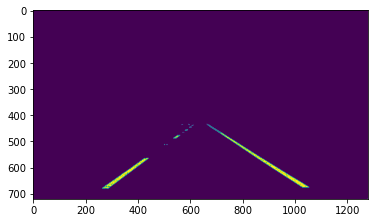

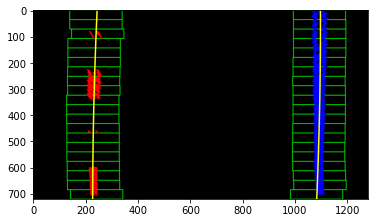

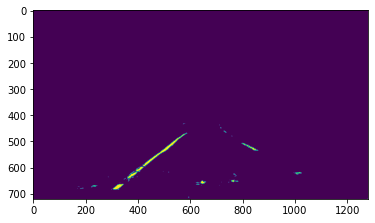

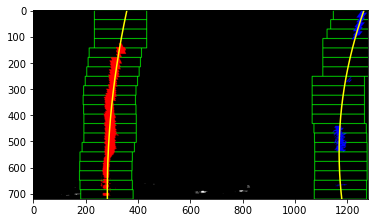

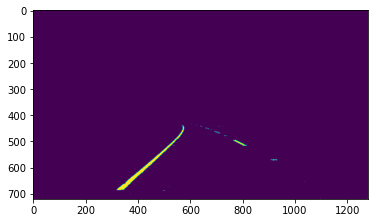

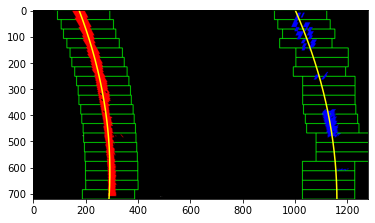

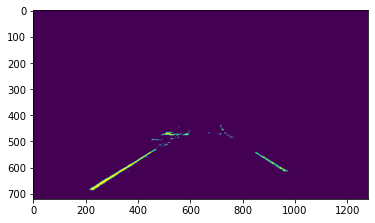

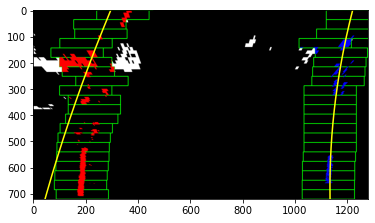

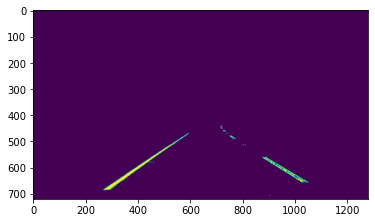

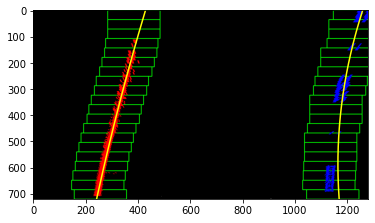

In [12]:
%matplotlib inline

for image in combined_images:
    
    # Obtain the region of interest
    roi, source_vertices = region_of_interest(image)
    
    bird_view_image = bird_view(roi)
    
    plt.imshow(roi)
    plt.show()
    #plt.imshow(bird_view_image)
#     plt.show()
    
    output = fit_model(bird_view_image)
    plt.imshow(output)
    plt.show()